In [1]:
import os
import torch
from torch import nn
from datetime import datetime
import random

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt
import glob
import bisect
import zipfile
import importlib

from Data_loader import PrcNorm, ThermoNorm

Get precip. normalizer

In [3]:
from pathlib import Path
parent_file_path=Path(r"/ocean/projects/ees220002p/fiaz/ocn/")
prc_path=parent_file_path/'prc_ocn'
hbl_path=parent_file_path/'hbl_ocn'
hlft_path=parent_file_path/'hlft_ocn'
hsat_lft_path=parent_file_path/'hsat_lft_ocn'

In [4]:
date_str='2015_01_01.npy'
imerg_prc=PrcNorm(str(prc_path/f'prc_oceans_{date_str}'))
imerg_prc.compute_norm()

In [5]:
era5_thermo=ThermoNorm(str(hbl_path/f'hbl_oceans_{date_str}'),
                        str(hlft_path/f'hlft_oceans_{date_str}'),
                        str(hsat_lft_path/f'hsat_lft_oceans_{date_str}'))
era5_thermo.compute_norm()

In [6]:
import Vae_model 
importlib.reload(Vae_model)

<module 'Vae_model' from '/jet/home/fiaz/precip-vae/training_scripts/Vae_model.py'>

In [7]:
cvae_params = dict(latent_dim=1, input_dim=3, encoder_dim=12, decoder_dim=12, device='cpu')
model = Vae_model.CVaePrecip(**cvae_params)

In [8]:
dst='/ocean/projects/ees220002p/fiaz/trained_models/cvae_precip_gamma/cvae_gamma_gauss_alpha_w=0.75_32_epochs.pth'
model.load_state_dict(torch.load(dst,map_location='cpu'))

<All keys matched successfully>

In [9]:
pcp_bins=2**(np.arange(-2.,8.125,0.125))
pcp_bins=np.insert(pcp_bins,0,1e-3)
pcp_bins=np.insert(pcp_bins,0,0)

pcp_bin_center=(pcp_bins[1:]+pcp_bins[:-1])*0.5
dx=np.diff(pcp_bins)

In [10]:
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

### Precip. as a function of therm for fixed z

In [16]:
class ModelEval:
    
    def __init__(self, **kw):
        
        self.model = kw['model']
        self.prc_std = kw['prc_std']
        self.pcp_bin_center = kw['pcp_bin_center']
        self.pcp_bins = kw['pcp_bins']
        self.plt_range = kw['plt_range']  # vmax and vmin
        self.cmap = kw['cmap']
        
        self.prc_hist = None
        self.prc_cond = torch.ones([kw['tensor_size'],1])
        self.create_scalar_mappable()
        self.multiplier = kw['multiplier']
        self.increment = kw['increment']
        
        self.cb_fmt = lambda x, pos: f'{x*self.multiplier+self.increment:.1f}'

             
    def create_scalar_mappable(self):
        vmin, vmax = self.plt_range
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        self.scalar_mappable = mpl.cm.ScalarMappable(norm=norm, cmap=self.cmap)



    def compute_prc_hist(self, z, input_tensor):
    
        log_alpha, log_mu, prob,v_=self.model.decoder(z, input_tensor, self.prc_cond)
        m1 = torch.distributions.Gamma(log_alpha.exp(), log_alpha.exp()/log_mu.exp())
        m2 = torch.distributions.Bernoulli(prob)

        prc_array = (m2.sample()*m1.sample()*self.prc_std).numpy().squeeze()

        prc_hist = np.histogram(prc_array,bins=pcp_bins)[0]
        self.prc_hist = prc_hist/(dx*prc_hist.sum())
        prob = prob.detach().numpy().squeeze()
        if np.all(np.isclose(prob,prob[0])):
            self.prob = prob[0]
        else:
            raise Exception('probability values are non unique!')
            
        
    def plot_hist(self, i, ax):
        
        col=self.scalar_mappable.to_rgba(i)
        '''
        ax is an array of axes
        '''
        ax[0].plot(self.pcp_bin_center, self.prc_hist, color=col, marker='*')
        ax[1].scatter(i*self.multiplier + self.increment, self.prob, color=col)
        
    def plot_annotate(self, ax, titles:list[str], cax):        
        ax[0].set_xlim(0,50)
        ax[0].set_yscale('log')
        ax[0].set_title(titles[0])
        
        ax[1].set_title(titles[1], fontsize=12)
        
        cb=plt.colorbar(self.scalar_mappable, cax=cax, 
                        format=FuncFormatter(self.cb_fmt))




In [17]:
def instantiate_fixedz(z_tensor, zval, thermo_tensor, dim, 
                       thermo_vals, model_params, cmap, ModelEval, 
                       multiplier, increment, ax):

    print(dim)
    if dim!=0 and dim!=1:
        raise ValueError('dim MUST be 0 or 1')
    
    model_params_copy=dict(model_params)

    model_params_copy.update(plt_range=[thermo_vals.min(), thermo_vals.max()],
                    multiplier=multiplier,
                    increment=increment,
                    cmap=cmap)
    
    obj=ModelEval(**model_params_copy)

    z_tensor[:] = zval
    
    for i in thermo_vals: 
        thermo_tensor[:,dim] = i  # subsat
        obj.compute_prc_hist(z_tensor, thermo_tensor)
        obj.plot_hist(i, ax)

    return obj



1
0


/tmp/ipykernel_20830/1305629619.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


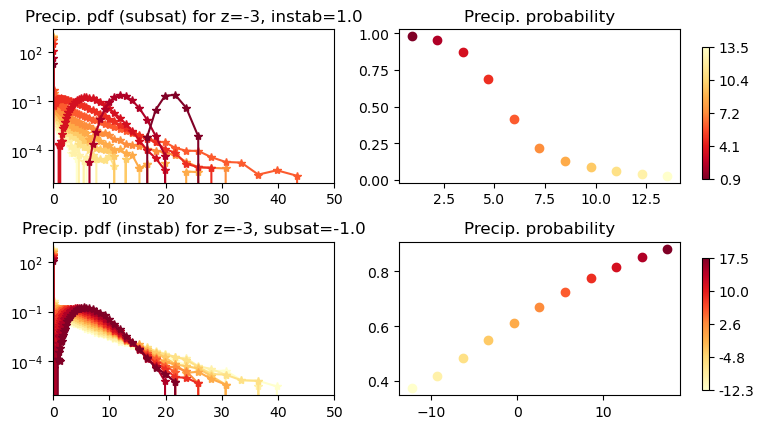

In [22]:
#create z 
syn_size=1_000_00
z_tensor=torch.normal(mean=0., std=1., size=(syn_size,cvae_params['latent_dim']))
prc_cond=torch.ones([syn_size,1])
zval=-3.0

## init class
model_params=dict(tensor_size=syn_size,prc_std=imerg_prc.precipitating_std, 
                 model=model, pcp_bins=pcp_bins,
                 pcp_bin_center=pcp_bin_center)

#create input_tensor 
thermo_tensor=torch.ones([syn_size,2])

#plot
fig,axx=plt.subplots(2,2,figsize=(7.,4.4))

## vary subsat ##
cax = fig.add_axes([1.01,0.58,0.01,0.3])
thermo_vals = np.arange(-2,2.2,.2)[::-2]  # varying subsaturation
multiplier = era5_thermo.subsat_std
increment = era5_thermo.subsat_mean

ax=axx[0,:]
obj = instantiate_fixedz(z_tensor, zval, thermo_tensor, 1, 
                         thermo_vals, model_params, 
                         plt.get_cmap('YlOrRd_r'), ModelEval, 
                         multiplier, increment, ax)

# obj=instantiate_fixedz(zvals, model_params, 
#                 plt.get_cmap('YlOrRd_r'), 
#                 ModelEval, muliplier, increment, 
#                 input_tensor, 1, ax)

titles=[f'Precip. pdf (subsat) for z={z_tensor.max():.0f}, instab={thermo_tensor[0,0]:.1f}', 'Precip. probability']
obj.plot_annotate(ax, titles, cax=cax)


## vary instab ##
cax = fig.add_axes([1.01,0.1,0.01,0.3])
ax=axx[1,:]

thermo_tensor[:,1]=-1.

thermo_vals = np.arange(-2,2.2,.2)[::2] # varying instability
multiplier = era5_thermo.instab_std
increment = era5_thermo.instab_mean

obj = instantiate_fixedz(z_tensor, zval, thermo_tensor, 0, 
                         thermo_vals, model_params, 
                         plt.get_cmap('YlOrRd'), ModelEval, 
                         multiplier, increment, ax)

titles=[f'Precip. pdf (instab) for z={z_tensor.max():.0f}, subsat={thermo_tensor[0,1]:.1f}', 'Precip. probability']
obj.plot_annotate(axx[1,:], titles, cax=cax)
plt.tight_layout()
    
    

### Precip. as a function of z for fixed thermo 

In [23]:
def instantiate_fixed_thermo(z_tensor, zvals, thermo_tensor, 
                       model_params, cmap, ModelEval, 
                       multiplier, increment, ax):
    
    model_params_copy=dict(model_params)
    model_params_copy.update(plt_range=[zvals.min(), zvals.max()],
                    multiplier=multiplier,
                    increment=increment,
                    cmap=cmap)
    obj=ModelEval(**model_params_copy)


    for i in zvals: 
        z_tensor[:] = i 
        obj.compute_prc_hist(z_tensor, thermo_tensor)
        obj.plot_hist(i, ax)

    return obj

/tmp/ipykernel_20830/3426433517.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


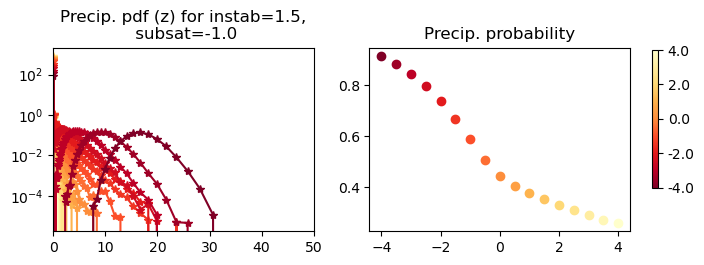

In [111]:
zvals=np.arange(-4,4.25,.25)[::-2]
thermo_tensor[:,0]=1.5
thermo_tensor[:,1]=-1.0

multiplier = 1.
increment = 0.

fig,ax=plt.subplots(1,2,figsize=(6.5,2.75))

cax = fig.add_axes([1.01,0.3,0.01,0.5])


obj = instantiate_fixed_thermo(z_tensor, zvals, thermo_tensor,
                       model_params, plt.get_cmap('YlOrRd_r'), ModelEval, 
                       multiplier, increment, ax)

titles=[f'Precip. pdf (z) for instab={thermo_tensor[0,0]:.1f},\n subsat={thermo_tensor[0,1]:.1f}', 'Precip. probability']
obj.plot_annotate(ax, titles, cax=cax)
plt.tight_layout()

Comparison to obs.

In [97]:
instab_bins = np.arange(-28,18,2)
subsat_bins = np.arange(-2,24,1)

prc_instab_cond_mean=np.zeros((instab_bins.size))
prc_subsat_cond_mean=np.zeros((subsat_bins.size))

prc_2D_cond_mean=np.zeros((instab_bins.size, subsat_bins.size))


bl_bins = np.arange(-26.,10.,1.)
prc_bl_cond_sum = np.zeros((bl_bins.size))
counts_bl_sum = np.zeros((bl_bins.size))
prc_bl_cond_mean = np.zeros((bl_bins.size))
prc_bl_jpdf = np.zeros((pcp_bin_center.size, bl_bins.size))

db=abs(np.diff(bl_bins)[0])

In [99]:
# note that prc_array size is fixed for each bin, so sum and mean are simple scaled transforms of each other
syn_size=1_000_00
z_tensor=torch.normal(mean=0.,std=1., size=(syn_size,cvae_params['latent_dim']))
prc_cond=torch.ones([syn_size,1])


for n,i in enumerate(instab_bins):
    
    for m,j in enumerate(subsat_bins):
        
        thermo_tensor=torch.ones([syn_size,2])
        thermo_tensor[:,0]=(i-era5_thermo.instab_mean)/era5_thermo.instab_std
        thermo_tensor[:,1]=(j-era5_thermo.subsat_mean)/era5_thermo.subsat_std

        log_alpha,log_mu, prob,_=model.decoder(z_tensor,thermo_tensor,prc_cond)
        m1=torch.distributions.Gamma(log_alpha.exp(),log_alpha.exp()/log_mu.exp())    
        m2=torch.distributions.Bernoulli(prob)

        prc_array= (m2.sample()*m1.sample()*imerg_prc.precipitating_std).numpy().squeeze()
        prc_2D_cond_mean[n,m]=prc_array.mean()
        
        bl = i*0.5-j*0.5  # compute lower trop. buoyancy
        bl_bin_indx=((bl-bl_bins[0])/db).astype('int')
        prc_bl_cond_sum[bl_bin_indx]+=prc_array.sum()
        counts_bl_sum[bl_bin_indx]+=syn_size
        prc_bl_jpdf[:,bl_bin_indx]+=np.histogram(prc_array, bins=pcp_bins)[0]


### Use IMERG data to plot obs. comparision 

In [78]:
import imerg_obs_comp 
importlib.reload(imerg_obs_comp)
from imerg_obs_comp import Imerg_era5_binning


DATE_STR=dt.datetime(2015,1,1).strftime('%Y_%m_%d')
imerg_path = [str(i) for i in (parent_file_path/'prc_ocn').glob(f'prc_oceans_{DATE_STR}.npy')][0]
hbl_path = [str(i) for i in (parent_file_path/'hbl_ocn').glob(f'hbl_oceans_{DATE_STR}.npy')][0]
hlft_path = [str(i) for i in (parent_file_path/'hlft_ocn').glob(f'hlft_oceans_{DATE_STR}.npy')][0]
hlft_sat_path = [str(i) for i in (parent_file_path/'hsat_lft_ocn').glob(f'hsat_lft_oceans_{DATE_STR}.npy')][0]
obj = Imerg_era5_binning(imerg_path, hbl_path, hlft_path, hlft_sat_path, instab_bins, subsat_bins, bl_bins)

In [79]:
obj.load_files_compute_instab_subsat()

In [87]:
prc_imerg_instab_binned,prc_imerg_subsat_binned, prc_imerg_bl_binned=obj.bin_imerg_1D()
prc_imerg_instab_sub_binned,prc_instab_subsat_jpdf=obj.bin_imerg_2D()
mask=np.ma.masked_invalid(prc_imerg_instab_sub_binned).mask


(0.0, 9.312174340029276)

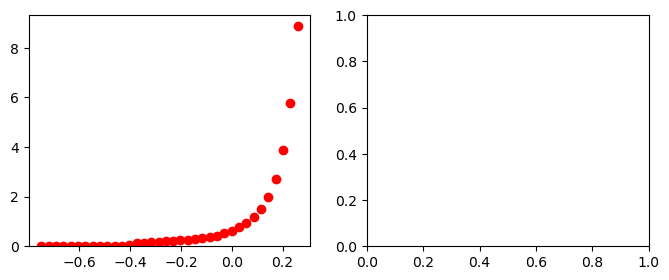

In [96]:
fig,axx=plt.subplots(1,2,figsize=(8.,3.))
ax=axx[0]
# ax.scatter(bl_bins*9.8/340., prc_imerg_bl_binned, c='blue')
ax.scatter(bl_bins*9.8/340., prc_bl_cond_sum/counts_bl_sum, c='red')
ax.set_ylim(bottom=0)

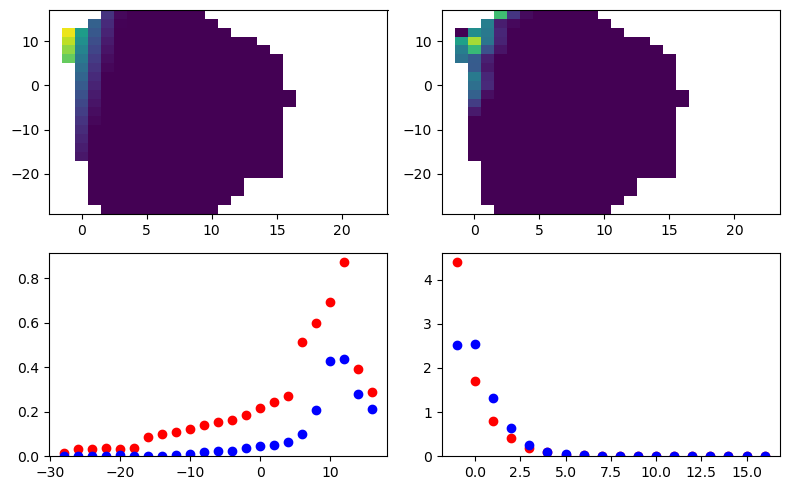

In [110]:
fig,axx=plt.subplots(2,2,figsize=(8.,5.))

# axx[0,0].set_yscale('log')
axx[0,0].pcolormesh(subsat_bins,instab_bins,
                    np.ma.masked_array(prc_2D_cond_mean,mask), 
                    vmin=0.5,vmax=5)

axx[0,1].pcolormesh(subsat_bins, instab_bins, 
                  prc_imerg_instab_sub_binned, vmin=0.5, vmax=5)

axx[1,0].scatter(instab_bins,np.ma.masked_array(prc_2D_cond_mean,mask).mean(1),color='red')
axx[1,0].scatter(instab_bins,prc_imerg_instab_binned,color='blue')

axx[1,0].set_ylim(bottom=0)

axx[1,1].scatter(subsat_bins,np.ma.masked_array(prc_2D_cond_mean,mask).mean(0),color='red')
axx[1,1].scatter(subsat_bins,prc_imerg_subsat_binned,color='blue')

axx[1,1].set_ylim(bottom=0)


# axx[1,0].set_ylim(bottom=0)

plt.tight_layout()